In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta


### Calcula y grafica la distribución posterior para las dos versiones A y B usando prior conjugado(2 pts).

In [2]:
data = pd.read_csv("ABtesting_zapatillas.csv")

# Parámetros del prior
alpha_prior = 10
beta_prior = 50

data_A = data["A"]
data_B = data["B"]

In [3]:
# Calcula los parámetros de la distribución posterior para A
alpha_posterior_A = alpha_prior + sum(data_A)
beta_posterior_A = beta_prior + len(data_A) - sum(data_A)

# Calcula los parámetros de la distribución posterior para B
alpha_posterior_B = alpha_prior + sum(data_B)
beta_posterior_B = beta_prior + len(data_B) - sum(data_B)


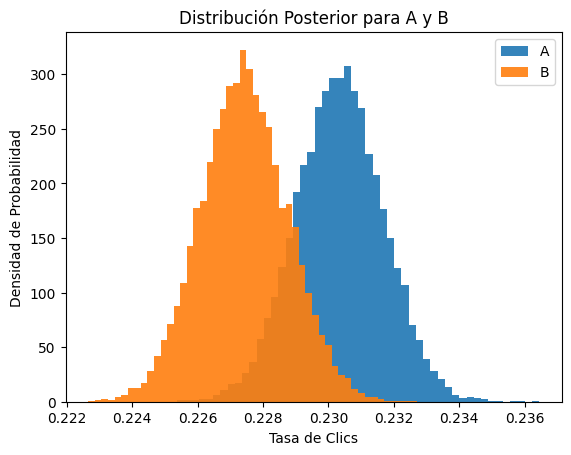

In [8]:
posterior_A = beta(alpha_prior + sum(data_A), beta_prior + len(data_A) - sum(data_A))
posterior_B = beta(alpha_prior + sum(data_B), beta_prior + len(data_B) - sum(data_B))

x = np.linspace(0, 1, 1000)
plt.hist(posterior_A.rvs(10000), bins=50, density=True, alpha=0.9, label='A')
plt.hist(posterior_B.rvs(10000), bins=50, density=True, alpha=0.9, label='B')
plt.xlabel('Tasa de Clics')
plt.ylabel('Densidad de Probabilidad')
plt.legend()
plt.title('Distribución Posterior para A y B')
plt.show()

### Calcula y grafica la distribución posterior para las dos versiones A y B usando muestreo Monte Carlo Markov Chain

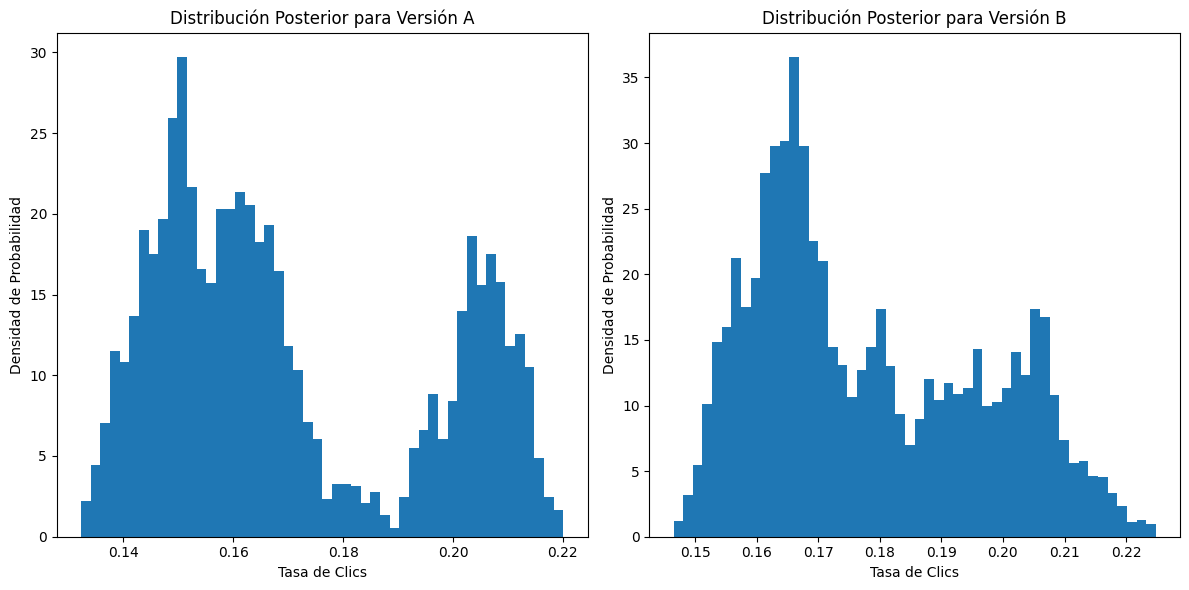

In [17]:
# Función para calcular la probabilidad posterior
def posterior_probability(data, alpha, beta):
    likelihood = np.prod(data)
    posterior = (alpha_prior + likelihood - 1) / (alpha_prior + beta_prior + len(data) - 2)
    return posterior

# Parámetros iniciales
alpha_A = alpha_prior
beta_A = beta_prior
alpha_B = alpha_prior
beta_B = beta_prior

# Número de iteraciones MCMC
num_iterations = 10000

# Listas para almacenar muestras
samples_A = []
samples_B = []

for _ in range(num_iterations):
    # Propuesta de nuevos valores
    alpha_A_proposed = np.random.normal(alpha_A, 0.05)
    beta_A_proposed = np.random.normal(beta_A, 0.05)
    alpha_B_proposed = np.random.normal(alpha_B, 0.05)
    beta_B_proposed = np.random.normal(beta_B, 0.05)
    
    # Calcular la probabilidad posterior para los valores propuestos
    posterior_current_A = posterior_probability(data_A, alpha_A, beta_A)
    posterior_proposed_A = posterior_probability(data_A, alpha_A_proposed, beta_A_proposed)
    
    posterior_current_B = posterior_probability(data_B, alpha_B, beta_B)
    posterior_proposed_B = posterior_probability(data_B, alpha_B_proposed, beta_B_proposed)
    
    # Aceptar o rechazar la propuesta con probabilidad
    accept_A = min(1, posterior_proposed_A / posterior_current_A)
    accept_B = min(1, posterior_proposed_B / posterior_current_B)
    
    if np.random.rand() < accept_A:
        alpha_A, beta_A = alpha_A_proposed, beta_A_proposed
    if np.random.rand() < accept_B:
        alpha_B, beta_B = alpha_B_proposed, beta_B_proposed
    
    samples_A.append((alpha_A, beta_A))
    samples_B.append((alpha_B, beta_B))

# Graficar las distribuciones posteriores resultantes
samples_A = np.array(samples_A)
samples_B = np.array(samples_B)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(samples_A[:, 0] / (samples_A[:, 0] + samples_A[:, 1]), bins=50, density=True, label='Versión A')
plt.xlabel('Tasa de Clics')
plt.ylabel('Densidad de Probabilidad')
plt.title('Distribución Posterior para Versión A')

plt.subplot(1, 2, 2)
plt.hist(samples_B[:, 0] / (samples_B[:, 0] + samples_B[:, 1]), bins=50, density=True, label='Versión B')
plt.xlabel('Tasa de Clics')
plt.ylabel('Densidad de Probabilidad')
plt.title('Distribución Posterior para Versión B')

plt.tight_layout()
plt.show()

### Cuál versión es mejor? Explica tu respuesta. 
La mejor version es prior conjugado ya que los datos se muestran mas exactos y tiende a una distribucion normal, lo que hace mas facil de entender

### Qué tan probable es que la versión A sea más efectiva?

In [19]:
probabilidad_A_mejor = np.mean(samples_B[:, 0] / (samples_B[:, 0] + samples_B[:, 1] > samples_A[:, 0] / (samples_A[:, 0] + samples_A[:, 1])))

print(f"La probabilidad de que la versión A sea más efectiva que la versión B es aproximadamente: {probabilidad_A_mejor:.2f} %")

La probabilidad de que la versión A sea más efectiva que la versión B es aproximadamente: 11.34 %


### Completa siguiente afirmación: Con 95% de probabilidad la tasa de clic de la versión (…) es hasta (…)% superior a la versión (…). (1 pto)

In [23]:
# Calcula la diferencia de tasas de clics entre A y B en cada muestra de MCMC
diferencia_tasas = (samples_A[:, 0] / (samples_A[:, 0] + samples_A[:, 1])) - (samples_B[:, 0] / (samples_B[:, 0] + samples_B[:, 1]))

# Calcula el intervalo de confianza del 95% para la diferencia
percentil_2p5 = np.percentile(diferencia_tasas, 2.5)
percentil_97p5 = np.percentile(diferencia_tasas, 97.5)

# Imprime la afirmación
print(f"Con un 95% de probabilidad, la tasa de clics de la versión A es hasta {percentil_97p5 - percentil_2p5:.2%} superior a la versión B.")


Con un 95% de probabilidad, la tasa de clics de la versión A es hasta 8.38% superior a la versión B.


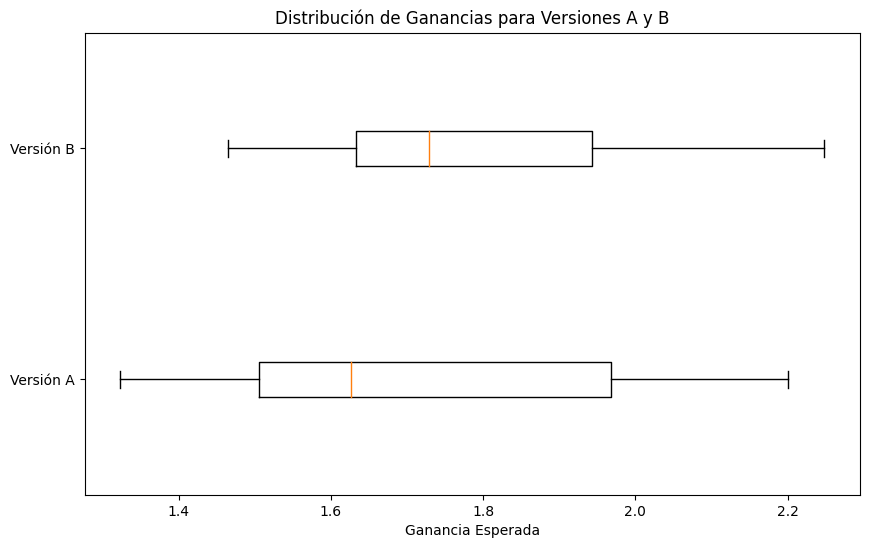

In [27]:
# Valor de ganancia por clic
valor_ganancia_por_clic = 10

# Calcula la ganancia esperada para cada versión
ganancia_esperada_A = samples_A[:, 0] / (samples_A[:, 0] + samples_A[:, 1]) * valor_ganancia_por_clic
ganancia_esperada_B = samples_B[:, 0] / (samples_B[:, 0] + samples_B[:, 1]) * valor_ganancia_por_clic

# Grafica el forest plot de las ganancias
plt.figure(figsize=(10, 6))
plt.boxplot([ganancia_esperada_A, ganancia_esperada_B], vert=False)
plt.yticks([1, 2], ['Versión A', 'Versión B'])
plt.xlabel('Ganancia Esperada')
plt.title('Distribución de Ganancias para Versiones A y B')

plt.show()
